# CC5215: Privacidad de Datos

## Laboratorio 9

Integrantes:

- Francisco Gutiérrez Albornoz

## Preamble

In this lab, we are going to implement the MWEM algorithm seen in class. Furthermore, we will incrementally build the necessary pieces of the algorithm in order to re-use the same logic for a private and a non-private version.

In [3]:
# Load the data and libraries
import pandas as pd
import numpy as np
import random
from scipy import stats
import matplotlib.pyplot as plt

def laplace_mech(v, sensitivity, epsilon):
    return v + np.random.laplace(loc=0, scale=sensitivity / epsilon)

def pct_error(orig, priv):
    return np.abs(orig - priv)/orig * 100.0

adult = pd.read_csv('https://users.dcc.uchile.cl/~mtoro/cursos/cc5215/adult_with_pii.csv')

## Question 1 (5 points)

The following code block shows the contingency table for the colums "Age" and "Occupation" in the dataset `adult`.

In [4]:
D = pd.crosstab(
    [adult['Age'], adult['Occupation']],
    np.ones(adult.shape[0]),
    normalize=True).rename(columns={1.0: "Norm_count"})

D

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.000749
    Craft-repair         0.000456
    Exec-managerial      0.000033
    Farming-fishing      0.000293
    Handlers-cleaners    0.001302
...                           ...
90  Other-service        0.000195
    Prof-specialty       0.000163
    Protective-serv      0.000033
    Sales                0.000098
    Transport-moving     0.000033

[843 rows x 1 columns]


Implement the `generate_n_qweights` function that creates a list of size `n` of binary weights (values being either 0 or 1) for a dataframe `D`:

_Hints_: Use the function `np.random.choice` to create a matrix with the dimentsions of `D` and use it to create a pd.Dataframe. Also, the properties `.shape`, `.index`, `.columns` of Dataframe may be useful.

In [5]:
def generate_n_qweights(D, n):
    """
    Generate a list of n dataframes, of the same structure as D, where each dataframe cell is either 0 or 1.

    Parameters:
        D (pd.Dataframe): The data for which the weight vectors will be generated
        n (int): The number of vectors to generate

    Returns:
        list(pd.Dataframe): A list of dataframes with the same shape of D, where each value is either 0 or 1

    Example:
        D = pd.Dataframe([0.1, 0.5, 0.4])
        qs = generate_n_qweights(D, 10)
        print(qs[0]) # Output: Dataframe([1, 0, 1])
    """
    return [pd.DataFrame(np.random.choice([0, 1], D.shape, p=[0.5, 0.5]), columns=D.columns, index=D.index) for _ in range(n)] 

qs = generate_n_qweights(D, 40)

qs[0]

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical                0
    Craft-repair                1
    Exec-managerial             0
    Farming-fishing             0
    Handlers-cleaners           1
...                           ...
90  Other-service               1
    Prof-specialty              0
    Protective-serv             1
    Sales                       0
    Transport-moving            1

[843 rows x 1 columns]

In [6]:
# TESTS

q_test = generate_n_qweights(D, 1)[0]

# This tests should NEVER fail
assert len(q_test) == len(D)
assert all([abs(w) <= 1 for w in q_test.values.flatten()])

## Question 2 (5 points)

From a `q` matrix, we can create a query `Q` that receives a dataframe `D` and calculates the weighted sum of `D` and `q`. Implement `generate_query_from_qweigth` that receives a `q` matrix and returns a tuple containing the same `q` and a function `Q`.

In [7]:
def generate_query_from_qweigth(q):
    """
    Generate a query function from a given query weight.

    Parameters:
        q (pd.Dataframe): The query weight vector.

    Returns:
        tuple: A tuple containing the query weight vector and the query function.
    """
    # Q = lambda x: (pd.DataFrame(x["Norm_count"].values, columns=x.columns) * q).values.sum()
    Q = lambda x: (x * q).values.sum()
    return (q, Q)

Qs = [generate_query_from_qweigth(q) for q in qs]

print("Query:", Qs[0][1])
print("=" * 50)
print("Query data:")
Qs[0][0]

Query: <function generate_query_from_qweigth.<locals>.<lambda> at 0x000002245A8AE7A0>
Query data:


col_0                  Norm_count
Age Occupation                   
17  Adm-clerical                0
    Craft-repair                1
    Exec-managerial             0
    Farming-fishing             0
    Handlers-cleaners           1
...                           ...
90  Other-service               1
    Prof-specialty              0
    Protective-serv             1
    Sales                       0
    Transport-moving            1

[843 rows x 1 columns]

## Question 3 (2 points)

For starting writing the MWEM implementation, the first step is to generate a first guess. Implement `gen_first_guess` that creates a dataframe similar to its argument `D`, but where each cell simply contains $\frac{1}{n}$, where $n$ is the size (number of cells) of `D`.

In [8]:
def gen_first_guess(D):
    n = D.shape[0]
    return pd.DataFrame([1 / n for _ in range(n)], columns=D.columns, index=D.index)

In [9]:
# TESTS

D0_test = gen_first_guess(D)

assert D0_test.shape == D.shape
assert np.isclose(D0_test.values.sum(), 1.0)

D0_test

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.001186
    Craft-repair         0.001186
    Exec-managerial      0.001186
    Farming-fishing      0.001186
    Handlers-cleaners    0.001186
...                           ...
90  Other-service        0.001186
    Prof-specialty       0.001186
    Protective-serv      0.001186
    Sales                0.001186
    Transport-moving     0.001186

[843 rows x 1 columns]

## Question 4 (6 points)

Our implementation of MWEM is going to be parametrized by the way we calculate the argmax error query, and the way we calculate the erorr/correction. Implement `get_i_max_nonDP`, that returns the index of the query that maximizes the error between `D` and `D_prev`. Additionally, implement `calc_correction_nonDP` that returns the `error` variable seen in class.

In [10]:
def get_i_max_nonDP(D, D_prev, queries):
    """
    Determine the index of the maximum query based on the absolute difference of query results.

    Parameters:
        D (pandas.DataFrame): The input data.
        D_prev (pandas.DataFrame): The previous distribution.
        queries (list(tuple)): List of pairs (a dataframe and a function) representing each query

    Returns:
        int: The index of the maximum query.
    """
    diff_queries_results = [abs(Q(D) - Q(D_prev)) for (_, Q) in queries]
    return np.argmax(diff_queries_results)

def calc_correction_nonDP(Q, D, D_prev):
    """
    Calculate the correction factor for a query without using differential privacy.

    Parameters:
        Q (function): The query function.
        D (pandas.DataFrame): The input data.
        D_prev (pandas.DataFrame): The previous distribution.

    Returns:
        float: The correction (or error) factor for the query.
    """
    return Q(D) - Q(D_prev)

In [11]:
# TESTS

D_prev_test = gen_first_guess(D)

assert get_i_max_nonDP(D, D_prev_test, Qs) < len(Qs)
assert abs(calc_correction_nonDP(Qs[0][1], D, D_prev_test)) < 1

## Question 5 (14 points)

We finally have all the parts necessary to build the MWEM algorithm. Implement MWEM as seen in class, with one subtlety: besides `D`, `queries` and `iterations`, the function must receive two functions that calculate the argmax error and the correction, respectively.

_Hint:_ As we are working with arithmetic over numbers between 0 and 1, it is probable that you may encounter floating approximation errors. It is recommended that you normalize the datasets you generate in each iteration to make sure that the elements sum up to exactly 1.

In [12]:
def MWEM_base(D, queries, iterations, get_i_max, calc_correction):
    """
    Perform the Multiplicative Weights Exponential Mechanism (MWEM) algorithm.

    Parameters:
        D (pandas.DataFrame): The input data.
        queries (list): List of queries to be performed in each iteration.
            Each query is a tuple containing its query data (dataframe, i.e. `q`s) and the query function (i.e. `Q`s).
        iterations (int): Number of iterations to perform.
        get_i_max (function): Function to determine the index of the maximum query.
            Signature: get_i_max(D, D_prev, queries) -> int
        calc_correction (function): Function to calculate the correction factor for a query.
            Signature: calc_correction(Query_max, D, D_prev) -> float

    Returns:
        pandas.DataFrame: The final result after performing the MWEM iterations.
    """
    
    D_prev = gen_first_guess(D)
    Ds = [D_prev]
    for i in range(1, iterations):
        q, Q = queries[get_i_max(D, D_prev, queries)]
        error = calc_correction(Q, D, D_prev)
        D_i = D_prev * np.exp(q * error / 2)
        Ds.append(D_i/D_i.values.sum())
    return sum(Ds)/iterations



We can now instantiate `MWEM_base` in the definition of `MWEM_nonDP` using the previously defined functions:

In [13]:
def MWEM_nonDP(D, queries, iterations):
    return MWEM_base(D, queries, iterations, get_i_max_nonDP, calc_correction_nonDP)

MWEM_result = MWEM_nonDP(D, Qs, 20)

MWEM_result

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.001171
    Craft-repair         0.001201
    Exec-managerial      0.001201
    Farming-fishing      0.001171
    Handlers-cleaners    0.001201
...                           ...
90  Other-service        0.001201
    Prof-specialty       0.001171
    Protective-serv      0.001201
    Sales                0.001201
    Transport-moving     0.001201

[843 rows x 1 columns]

In [14]:
# TEST

assert MWEM_result.shape == D.shape
assert np.isclose(MWEM_result.values.sum(), 1.0)

## Question 6 (8 points)

The following code-block shows the implementation of the exponential mechanism. Use `exponential` and `laplace_mech` to implement `get_i_max_DP` and `calc_correction_DP`, the differentially-private counterparts of the functions implemented in Question 4. Since these functions must receive the sensitivity and the epsilon and return the expected function by `MWEM_base`, e.g. `get_i_max_DP` is a function that takes `sensitivity` and `epsilon` and returns a new function that receives `D`, `D_prev` and `queries`.

In [15]:
def exponential(x, R, u, sensitivity, epsilon):
    # Calculate the score for each element of R
    scores = [u(x, r) for r in R]

    # Calculate the probability for each element, based on its score
    factors = [epsilon * score / (2 * sensitivity) for score in scores]
    probabilities = [np.exp(factor) for factor in factors]

    # Normalize the probabilties so they sum up to 1
    p_sum = sum(probabilities)
    probabilities = [float(p_i) / p_sum for p_i in probabilities]

    # Choose an element from R based on the probabilities
    return np.random.choice(R, 1, p=probabilities)[0]

In [ ]:
def get_i_max_DP(sensitivity, epsilon):
    def get_index(D, D_prev, queries):
        def calc_error(_, i):
            _, Q = queries[i]
            return abs(Q(D) - Q(D_prev))

        list_index = list(range(len(queries)))
        return exponential(None, list_index, calc_error, sensitivity, epsilon)

    return get_index

In [17]:
def calc_correction_DP(sensitivity, epsilon):
    def calc_error(Q, D, D_prev):
        error = Q(D) - Q(D_prev)
        return laplace_mech(error, sensitivity, epsilon)
    return calc_error

In [19]:
# Test

epsilon_test = 1.0

assert get_i_max_DP(1, epsilon_test)(D, D_prev_test, Qs) < len(Qs)

## Question 7 (6 points)

We can finally define `MWEM_DP` by instantiating `MWEM_base` with our differentially private definitions:

In [53]:
def MWEM_DP(D, queries, iterations, epsilon):
    return MWEM_base(D, queries, iterations, get_i_max_DP(1, epsilon / (2 * iterations)), calc_correction_DP(1, epsilon / (2 * iterations)))

# Just testing that it runs; no meaningful choice of #iterations or epsilon here.
DP_MWEM_result = MWEM_DP(D, Qs, 20, 80.0)

DP_MWEM_result

col_0                  Norm_count
Age Occupation                   
17  Adm-clerical         0.001262
    Craft-repair         0.001105
    Exec-managerial      0.001235
    Farming-fishing      0.001126
    Handlers-cleaners    0.001185
...                           ...
90  Other-service        0.001120
    Prof-specialty       0.001199
    Protective-serv      0.001140
    Sales                0.001172
    Transport-moving     0.001284

[843 rows x 1 columns]

If you have succesfully implemented MWEM (private and non-private) the following code should plot the responses for 40 new random queries, applied to the original dataframe, and the generated dataframes:

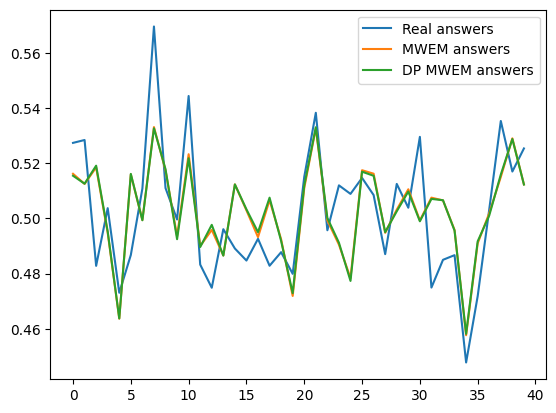

In [54]:
# Test how MWEM and DP-MWEM generalize

qs_test = generate_n_qweights(D, 40)
Qs_test = [generate_query_from_qweigth(q) for q in qs_test]

indexes = range(0, len(qs_test))
real_answers = [Q_i(D) for (_, Q_i) in Qs_test]
mwem_answers = [Q_i(MWEM_result) for (_, Q_i) in Qs_test]
dp_mwem_answers = [Q_i(DP_MWEM_result) for (_, Q_i) in Qs_test]

plt.plot(indexes, real_answers, label="Real answers")
plt.plot(indexes, mwem_answers, label="MWEM answers")
plt.plot(indexes, dp_mwem_answers, label="DP MWEM answers")

plt.legend()
plt.show()

- In a few sentences, and based on the previous plot, how would you describe the accuracy of the MWEM mechanism (both the private and non-private versions)?
- Why do you think it is sensible to generate 40 new queries instead of using the queries we already had?
- Notice that when we instantiated `get_i_max_DP` and `calc_correction_DP`, we specified a sensitivity of $1$ for our queries. Justify this decision.

**Respuestas**
- Lo que debería ocurrir es que MWEM no DP se acerque más a los datos reales y que MWEM DP tenga más error. En este caso, no es tan así y puede deberse a que el badget de privacidad es grande y las iteraciones son muy pocas lo cual también afecta a que ambas versiones tengan resultados parecidos.
- Porque así se evita que el mecanismo se sobreajuste a los datos reales y se mide una capacidad más realista del mismo.
- Por un lado porque es una counting query y además fijamos el peso en 0-1. A pesar de que esté normalizado al agregar un elemento al dataset cambiaría el resultado de la query en no más que 1.

## Question 8 (10 points)

The following code generates a plot that shows how the number of iterations in MWEM (non-private) affects the similarity between the original dataframe and the generated one:

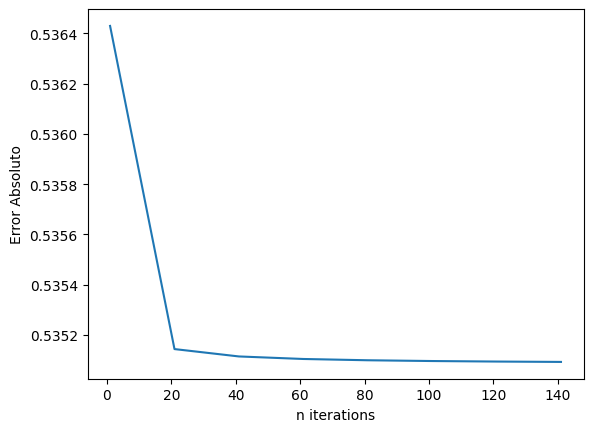

In [57]:
# KL divergence is a measure that can be used to measure the distance between
# two probability distributions
def KLdiv(P, Q):
    return (P * np.log(P / Q)).values.sum()

iterations = range(1, 150, 20)

errors_per_iteration = [KLdiv(D, MWEM_nonDP(D, Qs, iteration)) for iteration in iterations]

plt.xlabel("n iterations")
plt.ylabel("Error Absoluto")
plt.plot(iterations, errors_per_iteration)

- Describe the results showed in the figure
- In a few sentences, provide an intuition for such behavior

**Respuestas**
- Inicialmente el error es grande y llegado a un número de iteraciones disminuye llegando a un nivel de error estable.
- Esto podría explicarse debido a que inicialmente los pesos otorgados a los registros no sean del todo correcto, pero llegado a un punto el algoritmo converge (en este punto se espera que los pesos asignados generen resultados muy cercanos a los reales) y desde ese punto un ajuste en los pesos genera un cambio menor.

The following shows the same information as above but now for the DP version of MWEM:


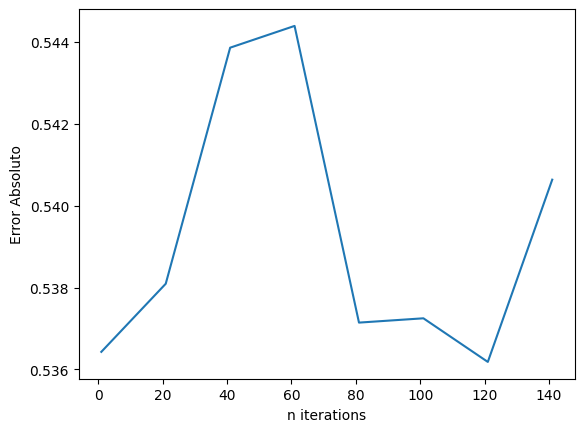

In [58]:
epsilon = 20.0

iterations = range(1, 150, 20)

errors_per_iteration_DP = [KLdiv(D, MWEM_DP(D, Qs, iteration, epsilon)) for iteration in iterations]

plt.xlabel("n iterations")
plt.ylabel("Error Absoluto")
plt.plot(iterations, errors_per_iteration_DP)

- Compare the two figures. What does it change?
- Why do you think we did not obtain the same behavior as before?
- (Without modifying the code) what should you change in order to "recover" the behavior of the previous figure?

**Respuestas**
- Los errores son un poco mayores en el caso DP. El comportamiento pareciera ser más errático (con esto me refiero a que no hay una zona de disminución/aumento y luego estabilización).
- Esto podría deberse principalmente al ruido agregado.
- Aumentar epsilon, así se agregaría menos ruido. 

## Question 9 (4 points)

Finally, write the necessary code (similar to the code blocks above 🙄) to plot how the DP MWEM reacts to different privacy budgets for a fixed number of iterations (20):

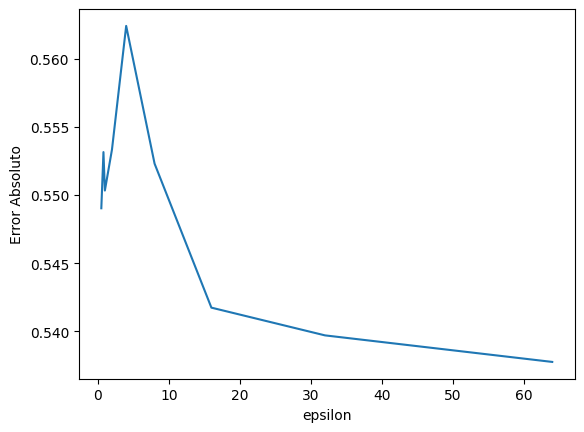

In [59]:
epsilons =  [0.5, 0.8, 1, 2, 4, 8, 16, 32, 64]

iterations = 20

errors_per_eps_DP = [KLdiv(D, MWEM_DP(D, Qs, iterations, ep)) for ep in epsilons]

plt.xlabel("epsilon")
plt.ylabel("Error Absoluto")
plt.plot(epsilons, errors_per_eps_DP)

- Based on the figure, what do you think is a "good" privacy budget **per iteration** for our dataframe? Explain your reasoning.
- Is your "good" budget-per-iteration similar to the one used in Q7? Is it smaller or bigger? Justify or argue against the budget used in Q7.

**Respuestas**
- Si quisieramos el mínimo posible para obtener un error no tan alto sería entre 10 y 20 (16 aprox) ya que en este punto la pendiente de la curva se hace menor, entonces la reducción marginal del error es menor.
- Mi buen epsilon es mucho menor que el de la Q7 y para cada iteración se tendría un epsilon un poco menor a 1, en cambio en la Q7 se tenía 4 por cada iteración. Para el epsilon usado en la Q7 se tiene un menor ruido pero eso también implica una menor privacidad, por lo cual es necesario disminuir ese valor considerando un trade off entre privacidad y utilidad.